<a href="https://colab.research.google.com/github/dineshb302/TERM2/blob/pushanb/MLUL_Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import sklearn
sklearn.__version__

'1.5.dev0'

If the version is higher than 1.3 it is fine.

If version is less than 1.3 then HDBSCAN will not work, so run the following

In [10]:
#!pip uninstall sklearn -y

In [11]:
#!pip install Cython

In [12]:
#!pip install git+https://github.com/scikit-learn/scikit-learn.git

  Cloning https://github.com/scikit-learn/scikit-learn.git to /tmp/pip-req-build-kuw0hixw
  Running command git clone --filter=blob:none --quiet https://github.com/scikit-learn/scikit-learn.git /tmp/pip-req-build-kuw0hixw
  Resolved https://github.com/scikit-learn/scikit-learn.git to commit 678e3999eeaadcaaef523d1d0d2f52a25986d460
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-learn: filename=scikit_learn-1.5.dev0-cp310-cp310-linux_x86_64.whl size=12038122 sha256=805e64a88538c2ab16def2702eb0885c0641d4988a823000727f9659cca44765
  Stored in directory: /tmp/pip-ephem-wheel-cache-5jr5tq12/wheels/33/2b/30/4298ac7ddb8056b3147c83f8a77e3af5b64a2463871af52c96
Successfully built scikit-learn
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [115]:
## Imports for clustering and visualization
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import HDBSCAN  ## in Version 1.3 of sklearn

In [5]:
## Imports for cluster evaluation
from yellowbrick.cluster import SilhouetteVisualizer

## Metric evaluation
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

In [6]:
## Read the Champo Carpets V1.csv dataset
data = 'https://raw.githubusercontent.com/dineshb302/TERM2/7143f5150720b80d83441c9939b6eca6214ef591/Champo%20Carpets%20V1.csv'
Champo = pd.read_csv(data)
#data_file = 'gdrive/My Drive/Champo Carpets V1.csv'
#Champo = pd.read_csv(data_file, encoding = 'UTF-8')
print("Shape: ",Champo.shape)
Champo.info()

Shape:  (13135, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13135 entries, 0 to 13134
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   OrderiD           13135 non-null  int64  
 1   Item_Id           13135 non-null  int64  
 2   CustomerCode      13135 non-null  object 
 3   CountryName       13135 non-null  object 
 4   customer_country  13135 non-null  object 
 5   QtyRequired       13135 non-null  int64  
 6   TotalArea         13135 non-null  float64
 7   Amount            13135 non-null  float64
 8   ITEM_NAME         13135 non-null  object 
 9   QualityName       13135 non-null  object 
 10  DesignName        13135 non-null  object 
 11  ColorName         13135 non-null  object 
 12  ShapeName         13135 non-null  object 
dtypes: float64(2), int64(3), object(8)
memory usage: 1.3+ MB


Data has no NULL values.

Checking the data.

In [7]:
# Checking the basic statistical values for numeric data in the dataset
Champo.describe()

,OrderiD,Item_Id,QtyRequired,TotalArea,Amount
count,13135.000000,13135.000000,13135.000000,13135.000000,13135.000000
mean,3075.336962,14528.683746,44.460601,44.731370,2392.040164
std,2107.731646,13183.139544,228.749535,50.099597,16832.091080
min,1.000000,1.000000,1.000000,0.040000,0.000000
25%,1219.500000,3023.000000,3.000000,5.800000,163.200000
50%,2934.000000,8631.000000,8.000000,24.000000,590.625000
75%,4630.000000,26713.000000,20.000000,80.000000,1540.000000
max,7548.000000,46701.000000,6400.000000,1024.000000,599719.680000


Removing some of the transactions where Amount is zero. They could be from coupons or other factors which should not impact our clustering process.

In [8]:
amt0 = Champo[(Champo['Amount']==0)]     ## Could be cases where the Customer has been given an offer/coupon
print('amt0 shape: ',amt0.shape)
Champo1 = Champo[(Champo['Amount']>0)]   ## dropping such transactions from our analysis
print('Champo1 shape: ', Champo1.shape)

amt0 shape:  (546, 13)
Champo1 shape:  (12589, 13)


**STAGE 1**

Deriving the Orders per Customer data

In [9]:
cust_order_cnt = Champo1.groupby(['CustomerCode'])['OrderiD'].nunique().reset_index()
cust_order_cnt[0:5]

,CustomerCode,OrderiD
0,A-11,11
1,A-6,2
2,A-9,205
3,B-2,8
4,B-3,11


Deriving the Total Amount billed by each customer

In [10]:
cust_amt_sum = Champo1.groupby(['CustomerCode'])['Amount'].sum().reset_index()
cust_amt_sum[0:5]

,CustomerCode,Amount
0,A-11,1.854041e+05
1,A-6,6.247460e+03
2,A-9,1.592080e+06
3,B-2,1.481116e+04
4,B-3,5.862686e+04


Merging the derived data to create the Customer Dataframe

In [81]:
cust_df = cust_order_cnt.merge(cust_amt_sum, on = 'CustomerCode')
cust_df.columns = ['CustomerCode','Order','Amount']
print(cust_df.shape)
cust_df[0:5]

(45, 3)


,CustomerCode,Order,Amount
0,A-11,11,1.854041e+05
1,A-6,2,6.247460e+03
2,A-9,205,1.592080e+06
3,B-2,8,1.481116e+04
4,B-3,11,5.862686e+04


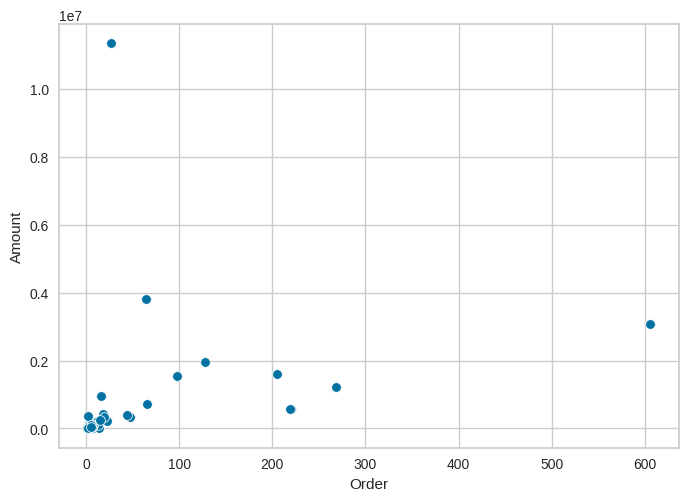

In [82]:
sn.scatterplot(data = cust_df,
               x = 'Order',
               y = 'Amount' );

Let's scale the data.

Standard Scaling

In [84]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
std_scale_cust_df = scaler.fit_transform( cust_df[['Order',
                                                  'Amount']] )

In [85]:
std_scale_cust_df = pd.DataFrame(std_scale_cust_df,
                                 columns = ['Order',
                                            'Amount'])
std_scale_cust_df[0:5]

,Order,Amount
0,-0.363582,-0.286682
1,-0.448208,-0.386838
2,1.460595,0.499714
3,-0.391791,-0.382051
4,-0.363582,-0.357556


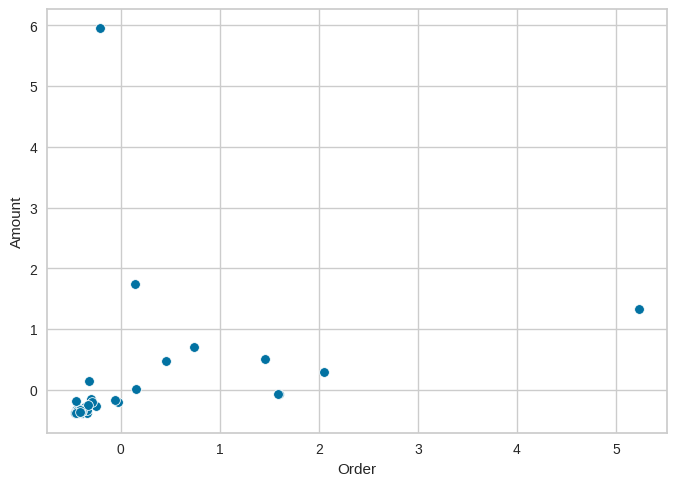

In [86]:
sn.scatterplot(data = std_scale_cust_df,
               x = 'Order',
               y = 'Amount' );

Min-Max Scaling

In [87]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
min_max_scale_cust_df = scaler.fit_transform( cust_df[['Order',
                                                       'Amount']] )

In [88]:
min_max_scale_cust_df = pd.DataFrame(min_max_scale_cust_df,
                                     columns = ['Order',
                                                'Amount'])
min_max_scale_cust_df[0:5]

,Order,Amount
0,0.016529,0.016320
1,0.001653,0.000522
2,0.337190,0.140357
3,0.011570,0.001277
4,0.016529,0.005141


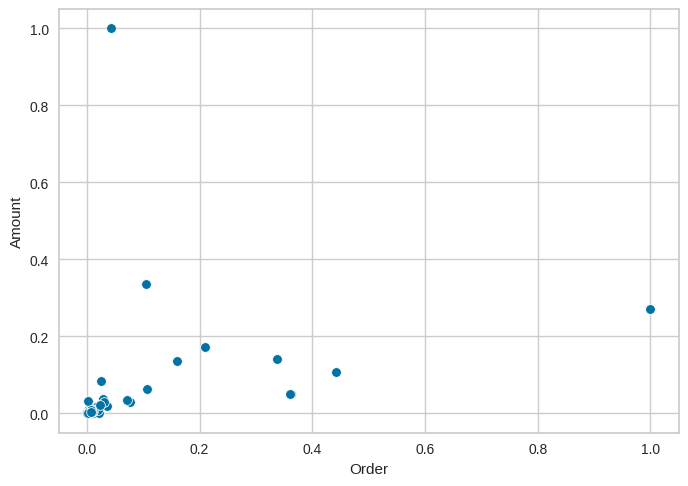

In [89]:
sn.scatterplot(data = min_max_scale_cust_df,
               x = 'Order',
               y = 'Amount' );

Logarithmic scaling

In [90]:
Log_scale_cust_df = cust_df
Log_scale_cust_df['Order'] = np.log10(cust_df['Order'])
Log_scale_cust_df['Amount']   = np.log10(cust_df['Amount'])
Log_scale_cust_df = Log_scale_cust_df.get(['Order','Amount'])
Log_scale_cust_df[0:5]

,Order,Amount
0,1.041393,5.268119
1,0.301030,3.795703
2,2.311754,6.201965
3,0.903090,4.170589
4,1.041393,4.768097


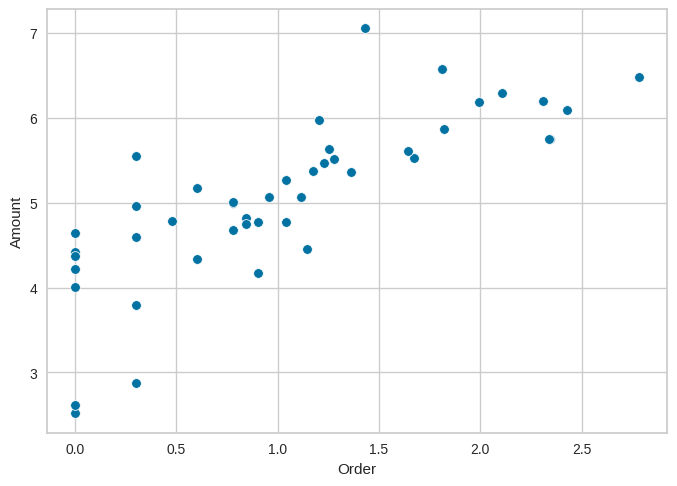

In [91]:
sn.scatterplot(data = Log_scale_cust_df,
               x = 'Order',
               y = 'Amount' );

**STAGE 2**

Now, using the scaled Dataframe for clustering Customers

In [92]:
## We can use any of the 3 scaled DF and create clusters
## for Standard Scaled data use std_scale_cust_df
## for Min-Max Scaled data use min_max_scale_cust_df
## for Log Scaled data use Log_scale_cust_df
## for no scaling use cust_df
scale_cust_df = Log_scale_cust_df    ## having tried all the scaling, Log scale gives better result

In [93]:
cluser_df = scale_cust_df.get(['Order','Amount'])
cluser_df.describe()

,Order,Amount
count,45.000000,45.000000
mean,1.033417,5.053994
std,0.765232,0.974197
min,0.000000,2.517031
25%,0.301030,4.598804
50%,0.954243,5.067362
75%,1.431364,5.630047
max,2.782473,7.054653


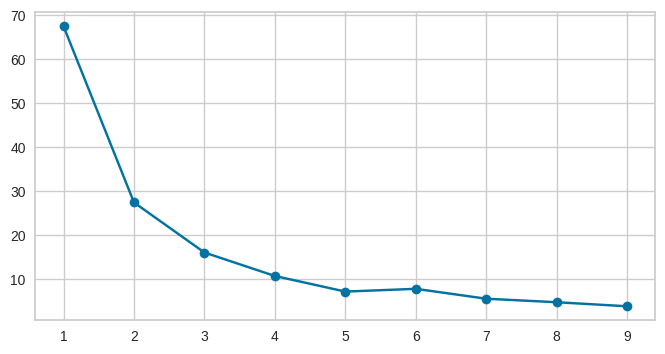

In [94]:
## KMEANS Clustering -- Elbow method
cluster_range = range( 1, 10 )
cluster_errors = []

for num_clusters in cluster_range:
  clusters = KMeans( num_clusters )
  clusters.fit( cluser_df )
  cluster_errors.append( clusters.inertia_ )

plt.figure(figsize=(8,4))
plt.plot( cluster_range, cluster_errors, marker = "o" );

Evaluating the cluster with k in (4,5,6,7)

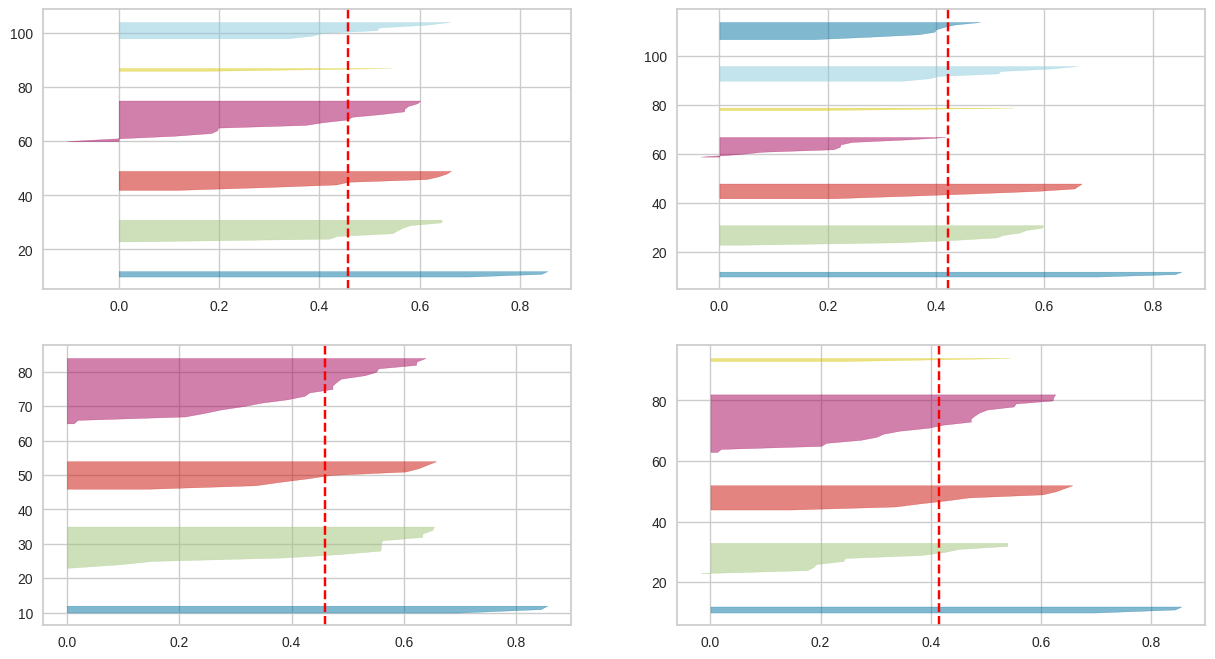

In [71]:
## Silhouette Visualization

fig, ax = plt.subplots(2, 2, figsize=(15,8))
num_clusters = [4, 5, 6, 7]
for i, k in enumerate(num_clusters):
    km = KMeans(n_clusters=k,
                random_state=42)
    q, mod = divmod(i, 2)
    visualizer = SilhouetteVisualizer(km,
                                      colors='yellowbrick',
                                      ax=ax[q-1][mod])
    visualizer.fit(cluser_df)

Creating 5 clusters by K-Means clustering algorithm as itshow no area in the negative part (no wrongly allocated customer)

In [96]:
k = 5

clusters = KMeans( k, random_state = 42 )
clusters.fit( cluser_df )

KMeans(n_clusters=5, random_state=42)

Understanding the clusters.

In [97]:
scale_cust_df['clusterid'] = clusters.labels_

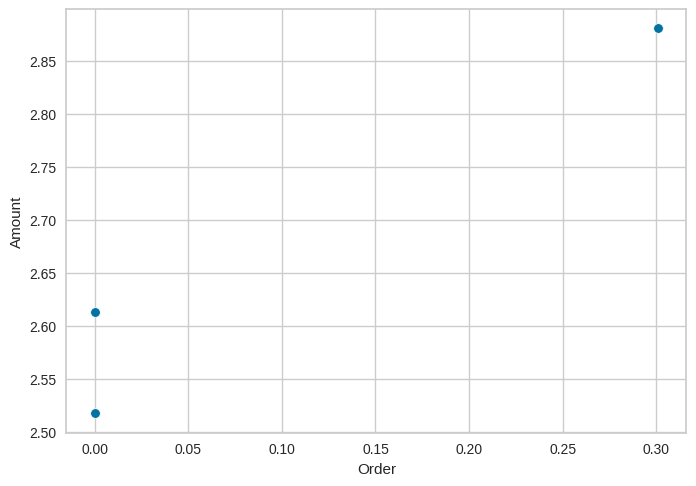

In [98]:
## Cluster 0
sn.scatterplot(data = scale_cust_df[scale_cust_df['clusterid']==0],
               x = 'Order',
               y = 'Amount' );

Cluster 0 are customers with low order and low Amount => Churners



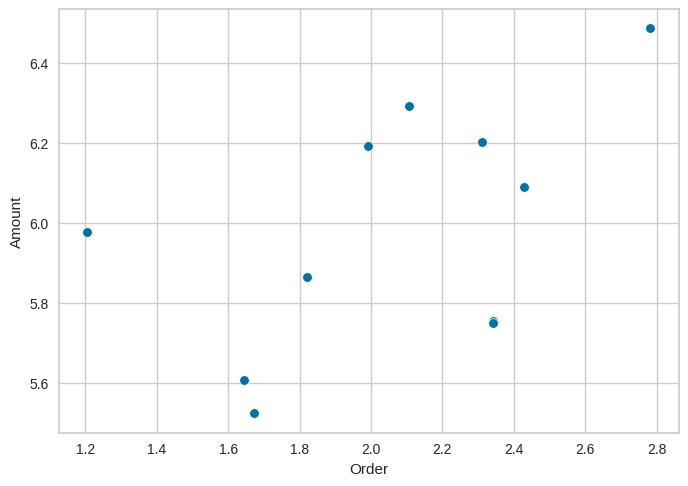

In [99]:
## Cluster 1
sn.scatterplot(data = scale_cust_df[scale_cust_df['clusterid']==1],
               x = 'Order',
               y = 'Amount' );

Cluster 1 are customers who have moderately high number of orders and moderately high amount billed. => Stars

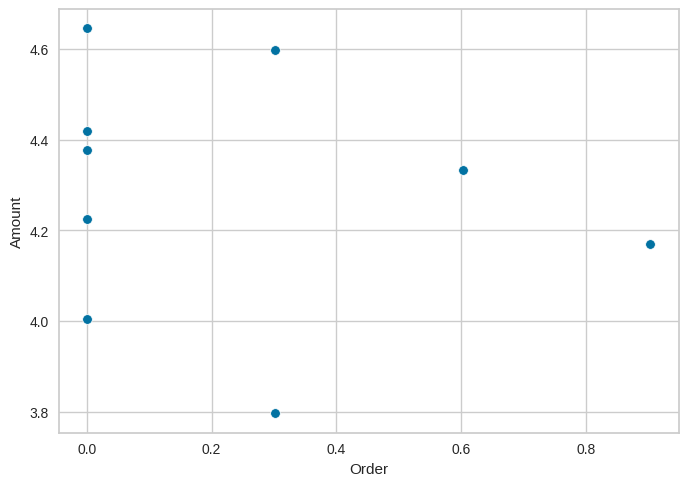

In [100]:
## Cluster 2
sn.scatterplot(data = scale_cust_df[scale_cust_df['clusterid']==2],
               x = 'Order',
               y = 'Amount' );

Cluster 2 are customers with low orders but high amount billed => Exclusive

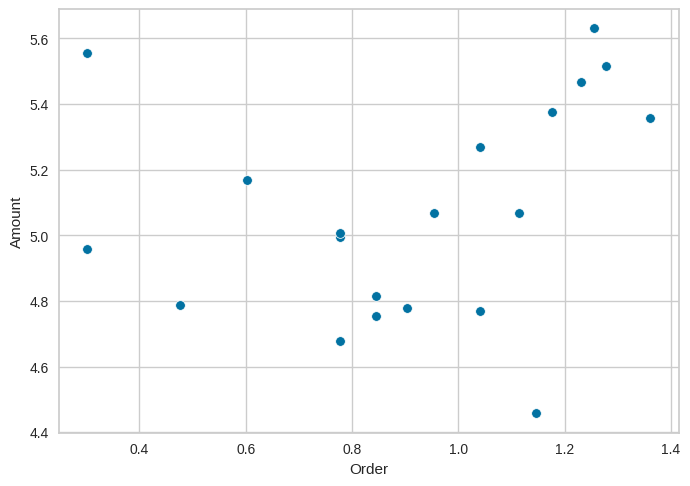

In [101]:
## Cluster 3
sn.scatterplot(data = scale_cust_df[scale_cust_df['clusterid']==3],
               x = 'Order',
               y = 'Amount' );

Cluster 3 are customers with moderate orders and moderate amount billed => Consinstent

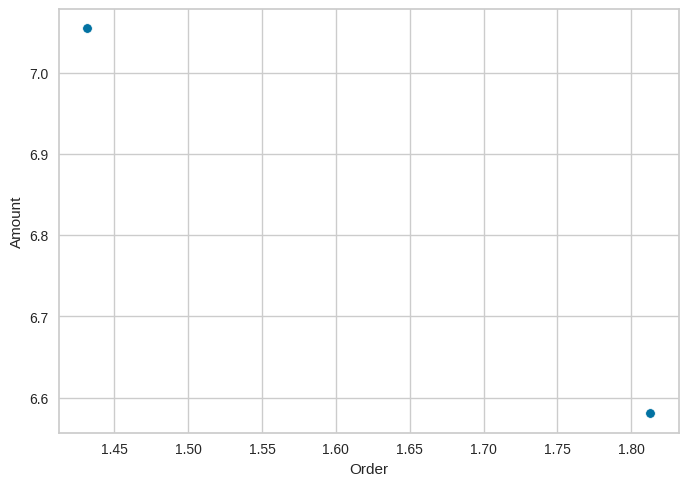

In [102]:
## Cluster 4
sn.scatterplot(data = scale_cust_df[scale_cust_df['clusterid']==4],
               x = 'Order',
               y = 'Amount' );

Cluster 4 are customers with high Order and high Amount.

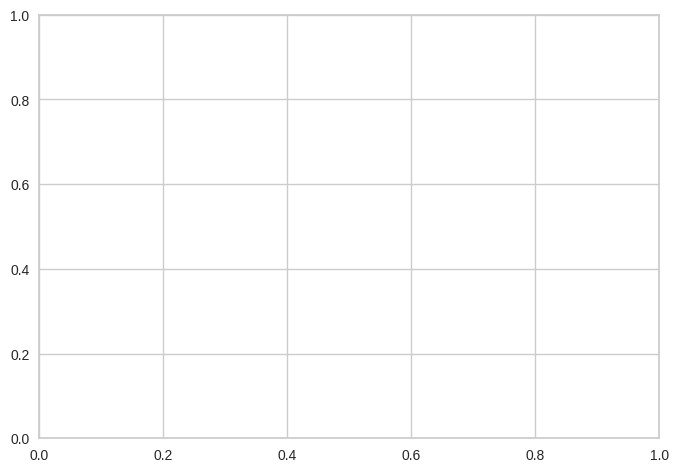

In [103]:
## Cluster 5
sn.scatterplot(data = scale_cust_df[scale_cust_df['clusterid']==5],
               x = 'Order',
               y = 'Amount' );

Evalauating the clusters

In [104]:
## Calinski-Harabasz Index => Relative measure (higher the value greater is the clustering performance)

cluster_range = range( 2, 8 )
ch_scores = []

for num_clusters in cluster_range:
  clusters = KMeans( num_clusters )
  clusters.fit( cluser_df )
  print(f"n_cluster: {num_clusters} - CH Score: {calinski_harabasz_score(cluser_df, clusters.labels_)}" )

n_cluster: 2 - CH Score: 62.72816429925666
n_cluster: 3 - CH Score: 67.1645093414837
n_cluster: 4 - CH Score: 75.01796447248809
n_cluster: 5 - CH Score: 86.79607650783538
n_cluster: 6 - CH Score: 88.11401483181787
n_cluster: 7 - CH Score: 88.61239743925164


In [105]:
## Davies-Bouldin Index => lower value means better clustering

cluster_range = range( 2, 8)
ch_scores = []

for num_clusters in cluster_range:
  clusters = KMeans( num_clusters )
  clusters.fit( cluser_df )
  print(f"n_cluster: {num_clusters} - Davies-Bouldin Index: {davies_bouldin_score(cluser_df, clusters.labels_)}" )

n_cluster: 2 - Davies-Bouldin Index: 0.6940054126979258
n_cluster: 3 - Davies-Bouldin Index: 0.7197667338172545
n_cluster: 4 - Davies-Bouldin Index: 0.667612684386071
n_cluster: 5 - Davies-Bouldin Index: 0.6335833825980901
n_cluster: 6 - Davies-Bouldin Index: 0.6643580766935561
n_cluster: 7 - Davies-Bouldin Index: 0.6939418048704551


Hierarchical Clustering

In [106]:
## Agglomerative Clustering using euclidean

h_cluster = AgglomerativeClustering(n_clusters = 5,
                                    metric = 'euclidean',
                                    linkage = 'ward',           ## minimizes the variance of the clusters being merged
                                    compute_distances = True)

In [107]:
h_cluster.fit(cluser_df)

AgglomerativeClustering(compute_distances=True, n_clusters=5)

In [110]:
scale_cust_df['hcluster_clusterid'] = h_cluster.labels_
scale_cust_df[0:5]
hcluster = scale_cust_df.groupby(['hcluster_clusterid'])['hcluster_clusterid'].count()
print(hcluster)

hcluster_clusterid
0     9
1    19
2     3
3     9
4     5
Name: hcluster_clusterid, dtype: int64


Similar split like K-Means

In [111]:
h_cluster.n_leaves_

45

In [112]:
h_cluster.children_

array([[ 6, 38],
       [ 8, 41],
       [ 5, 10],
       [17, 36],
       [21, 48],
       [30, 35],
       [28, 33],
       [16, 22],
       [ 7, 27],
       [12, 13],
       [39, 50],
       [ 2, 20],
       [44, 49],
       [14, 47],
       [32, 55],
       [ 0, 54],
       [24, 37],
       [ 4, 57],
       [19, 59],
       [ 9, 46],
       [15, 25],
       [ 3, 23],
       [ 1, 34],
       [40, 51],
       [53, 56],
       [61, 65],
       [42, 52],
       [11, 66],
       [60, 64],
       [18, 43],
       [29, 63],
       [58, 67],
       [45, 69],
       [62, 73],
       [31, 77],
       [68, 75],
       [26, 70],
       [72, 78],
       [81, 82],
       [74, 79],
       [76, 83],
       [80, 84],
       [71, 85],
       [86, 87]])

In [113]:
h_cluster.distances_

array([3.99757878e-03, 1.05060678e-02, 4.24282488e-02, 6.15598976e-02,
       6.75104364e-02, 6.95702844e-02, 8.76947485e-02, 9.57522019e-02,
       1.53067888e-01, 1.59700998e-01, 1.60031076e-01, 1.61175054e-01,
       1.64687312e-01, 1.99164827e-01, 2.00698627e-01, 2.31839127e-01,
       2.44717600e-01, 2.51560298e-01, 2.54026516e-01, 2.80906025e-01,
       3.04669595e-01, 3.41814491e-01, 3.66467511e-01, 3.93654656e-01,
       4.73479861e-01, 4.89339811e-01, 5.03380718e-01, 5.12683892e-01,
       5.65246921e-01, 6.08737105e-01, 6.59804290e-01, 7.20564621e-01,
       7.53086213e-01, 7.87065539e-01, 9.00594713e-01, 9.47819355e-01,
       1.02201022e+00, 1.35162150e+00, 1.66401297e+00, 1.76444015e+00,
       2.65153899e+00, 3.06752664e+00, 4.80939424e+00, 8.95235583e+00])

Density Based Clustering using HDBSCAN

In [116]:
## Needto set the min cluster size
hdbscan = HDBSCAN(min_cluster_size=2)

In [117]:
hdbscan.fit(cluser_df)

HDBSCAN(min_cluster_size=2)

In [118]:
hdbscan.labels_

array([ 8, -1,  5,  1,  9,  7,  2,  4, 11, -1,  7, -1, 10, 10,  7,  6,  0,
        9, -1,  8,  5,  9,  0,  1,  6,  7, -1,  4,  3, -1,  8, -1,  8,  3,
        7,  8,  9,  6,  2,  8,  3, 11,  0, -1,  9])

In [123]:
scale_cust_df['hdbscan_clusterid'] = hdbscan.labels_
scale_cust_df[0:5]
dbcluster = scale_cust_df.groupby(['hdbscan_clusterid'])['hdbscan_clusterid'].count()
print(dbcluster)

hdbscan_clusterid
-1     8
 0     3
 1     2
 2     2
 3     3
 4     2
 5     2
 6     3
 7     5
 8     6
 9     5
 10    2
 11    2
Name: hdbscan_clusterid, dtype: int64


12 clusters created for 45 customers => tough to interpretation

**STAGE 3:** Now, will generate another feature and repeat the clustering technique for the new customer Dataframe.

Deriving the number of unique items ordered by each customer

In [124]:
cust_uni_item = Champo1.groupby(['CustomerCode'])['Item_Id'].nunique().reset_index()
cust_uni_item.columns = ['CustomerCode','UniqueCount']
cust_uni_item[0:5]

,CustomerCode,UniqueCount
0,A-11,23
1,A-6,25
2,A-9,504
3,B-2,44
4,B-3,72


In [130]:
cust_df_new = cust_order_cnt.merge(cust_amt_sum, on = 'CustomerCode').merge(cust_uni_item, on = 'CustomerCode')
cust_df_new.columns = ['CustomerCode','Quantity','Amount','UniqueItems']
print(cust_df_new.shape)
cust_df_new[0:5]

(45, 4)


,CustomerCode,Quantity,Amount,UniqueItems
0,A-11,11,1.854041e+05,23
1,A-6,2,6.247460e+03,25
2,A-9,205,1.592080e+06,504
3,B-2,8,1.481116e+04,44
4,B-3,11,5.862686e+04,72


In [131]:
## Standard Scaling on the new DF
scaler = StandardScaler()
std_scale_cust_df = scaler.fit_transform( cust_df_new[['Quantity',
                                                       'Amount',
                                                       'UniqueItems']] )
std_scale_cust_df = pd.DataFrame(std_scale_cust_df,
                                 columns = ['Quantity',
                                            'Amount',
                                            'UniqueItems'])
std_scale_cust_df[0:5]

,Quantity,Amount,UniqueItems
0,-0.363582,-0.286682,-0.628380
1,-0.448208,-0.386838,-0.616591
2,1.460595,0.499714,2.206993
3,-0.391791,-0.382051,-0.504590
4,-0.363582,-0.357556,-0.339537


In [132]:
## Min-Max Scaling on the new DF
scaler = MinMaxScaler()
min_max_scale_cust_df = scaler.fit_transform( cust_df_new[['Quantity',
                                                           'Amount',
                                                           'UniqueItems']] )
min_max_scale_cust_df = pd.DataFrame(min_max_scale_cust_df,
                                     columns = ['Quantity',
                                                'Amount',
                                                'UniqueItems'])
min_max_scale_cust_df[0:5]

,Quantity,Amount,UniqueItems
0,0.016529,0.016320,0.028947
1,0.001653,0.000522,0.031579
2,0.337190,0.140357,0.661842
3,0.011570,0.001277,0.056579
4,0.016529,0.005141,0.093421


In [134]:
## Logarithmic scaling on the new DF
Log_scale_cust_df = cust_df_new
Log_scale_cust_df['Quantity'] = np.log10(cust_df_new['Quantity'])
Log_scale_cust_df['Amount']   = np.log10(cust_df_new['Amount'])
Log_scale_cust_df['UniqueItems']   = np.log10(cust_df_new['UniqueItems'])
Log_scale_cust_df = Log_scale_cust_df.get(['Quantity','Amount','UniqueItems'])
Log_scale_cust_df[0:5]

,Quantity,Amount,UniqueItems
0,1.041393,5.268119,1.361728
1,0.301030,3.795703,1.397940
2,2.311754,6.201965,2.702431
3,0.903090,4.170589,1.643453
4,1.041393,4.768097,1.857332


Now, we create clusters with the 3 scaled DF to find the best clusters

In [153]:
## std_scale_cust_df
## min_max_scale_cust_df
## Log_scale_cust_df

scale_cust_df = Log_scale_cust_df    ## after having tried the 3 DFs, it is seen that Log Scale gives a better result

In [154]:
cluster_df = scale_cust_df.get(['Quantity','Amount','UniqueItems'])
cluster_df.describe()

,Quantity,Amount,UniqueItems
count,45.000000,45.000000,45.000000
mean,1.033417,5.053994,1.694038
std,0.765232,0.974197,0.712423
min,0.000000,2.517031,0.000000
25%,0.301030,4.598804,1.255273
50%,0.954243,5.067362,1.748188
75%,1.431364,5.630047,2.173186
max,2.782473,7.054653,2.881385


Using the Elbow method to identify the number clusters exist in the data

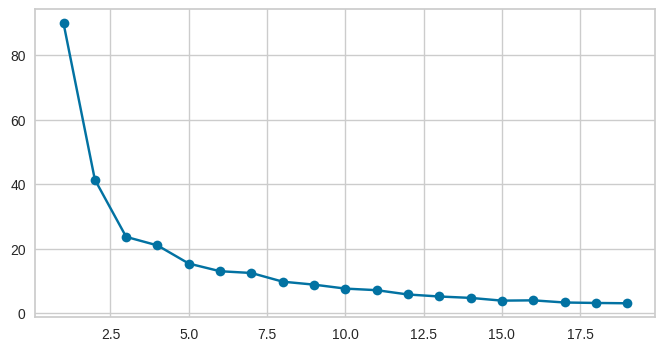

In [155]:
## KMEANS Clustering -- Elbow method
cluster_range = range( 1, 20 )
cluster_errors = []

for num_clusters in cluster_range:
  clusters = KMeans( num_clusters )
  clusters.fit( cluster_df )
  cluster_errors.append( clusters.inertia_ )

plt.figure(figsize=(8,4))
plt.plot( cluster_range, cluster_errors, marker = "o" );

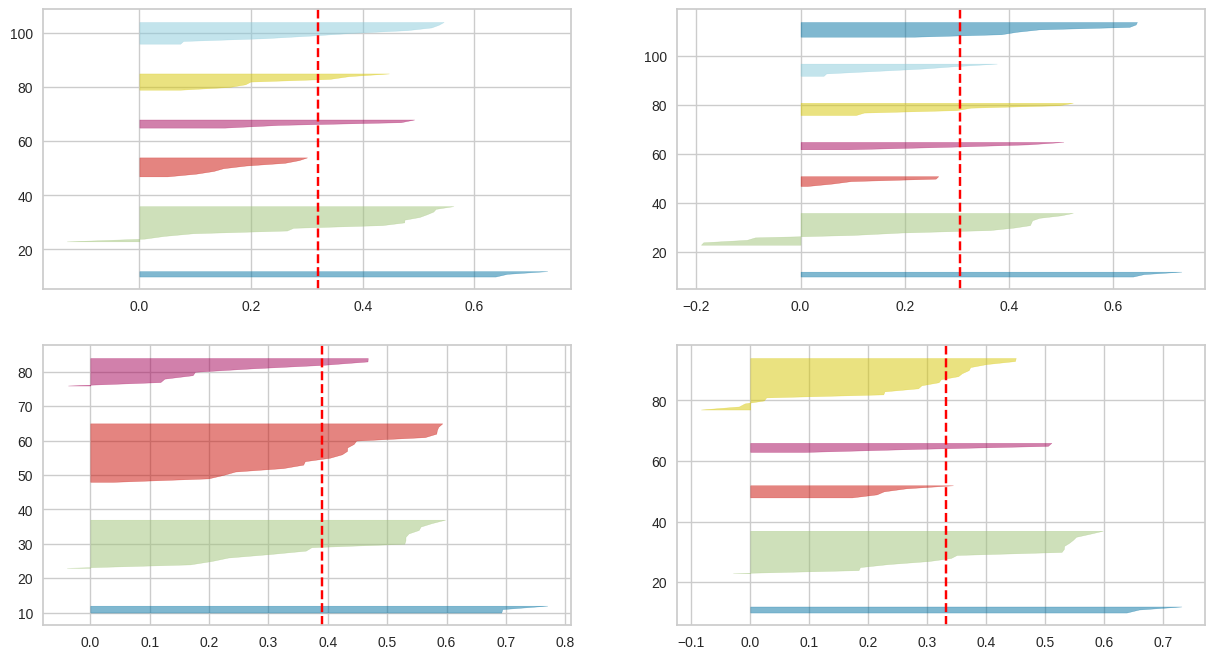

In [167]:
## Silhouette Visualization

fig, ax = plt.subplots(2, 2, figsize=(15,8))
num_clusters = [4, 5, 6, 7]
for i, k in enumerate(num_clusters):
    km = KMeans(n_clusters=k,
                random_state=42)
    q, mod = divmod(i, 2)
    visualizer = SilhouetteVisualizer(km,
                                      colors='yellowbrick',
                                      ax=ax[q-1][mod])
    visualizer.fit(cluster_df)

Creating 4 clusters as the graph shows little area in the negative zone (better compared to the rest)

In [168]:
k = 4

clusters = KMeans( k, random_state = 42 )
clusters.fit( cluster_df )

scale_cust_df['clusterid'] = clusters.labels_

In [169]:
## Cluster 0
scale_cust_df[scale_cust_df['clusterid']==0].describe()

,Quantity,Amount,UniqueItems,clusterid
count,3.000000,3.000000,3.000000,3.0
mean,0.100343,2.670013,0.482386,0.0
std,0.173800,0.188239,0.314118,0.0
min,0.000000,2.517031,0.301030,0.0
25%,0.000000,2.564907,0.301030,0.0
50%,0.000000,2.612783,0.301030,0.0
75%,0.150515,2.746504,0.573064,0.0
max,0.301030,2.880225,0.845098,0.0


In [170]:
## Cluster 1
scale_cust_df[scale_cust_df['clusterid']==1].describe()

,Quantity,Amount,UniqueItems,clusterid
count,15.000000,15.000000,15.000000,15.0
mean,1.894745,6.034906,2.342079,1.0
std,0.485879,0.441759,0.359787,0.0
min,1.204120,5.516259,1.556303,1.0
25%,1.537408,5.690316,2.140971,1.0
50%,1.819544,5.977438,2.346353,1.0
75%,2.326099,6.247088,2.626402,1.0
max,2.782473,7.054653,2.881385,1.0


In [171]:
## Cluster 2
scale_cust_df[scale_cust_df['clusterid']==2].describe()

,Quantity,Amount,UniqueItems,clusterid
count,18.000000,18.000000,18.000000,18.0
mean,0.877738,4.900820,1.768722,2.0
std,0.329625,0.359923,0.315653,0.0
min,0.000000,4.170589,1.230449,2.0
25%,0.778151,4.697785,1.539726,2.0
50%,0.903090,4.905689,1.714715,2.0
75%,1.095806,5.143654,1.925518,2.0
max,1.361728,5.466192,2.419956,2.0


In [172]:
## Cluster 3
scale_cust_df[scale_cust_df['clusterid']==3].describe()

,Quantity,Amount,UniqueItems,clusterid
count,9.000000,9.000000,9.000000,9.0
mean,0.220252,4.520149,0.868486,3.0
std,0.230591,0.534228,0.459723,0.0
min,0.000000,3.795703,0.000000,3.0
25%,0.000000,4.225309,0.698970,3.0
50%,0.301030,4.376577,1.000000,3.0
75%,0.301030,4.787942,1.146128,3.0
max,0.602060,5.554961,1.397940,3.0


In [173]:
## Cluster 4
scale_cust_df[scale_cust_df['clusterid']==4].describe()

,Quantity,Amount,UniqueItems,clusterid
count,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN


In [174]:
## Cluster 5
scale_cust_df[scale_cust_df['clusterid']==5].describe()

,Quantity,Amount,UniqueItems,clusterid
count,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN


Evaluating the cluster

In [175]:
## Calinski-Harabasz Index => Relative measure (higher the value greater is the clustering performance)

cluster_range = range( 4, 8 )
ch_scores = []

for num_clusters in cluster_range:
  clusters = KMeans( num_clusters )
  clusters.fit( cluster_df )
  print(f"n_cluster: {num_clusters} - CH Score: {calinski_harabasz_score(cluster_df, clusters.labels_)}" )

n_cluster: 4 - CH Score: 52.28728444660293
n_cluster: 5 - CH Score: 50.07744975398921
n_cluster: 6 - CH Score: 45.58061925689153
n_cluster: 7 - CH Score: 42.22908707630108


A CH Index of 52.28 is good given it is highest compared to the other cluster models.

In [180]:
## Davies-Bouldin Index => lower value means better clustering

cluster_range = range( 4, 8 )
ch_scores = []

for num_clusters in cluster_range:
  clusters = KMeans( num_clusters )
  clusters.fit( cluster_df )
  print(f"n_cluster: {num_clusters} - Davies-Bouldin Score: {davies_bouldin_score(cluster_df, clusters.labels_)}" )

n_cluster: 4 - Davies-Bouldin Score: 0.8193182780312345
n_cluster: 5 - Davies-Bouldin Score: 0.8418619728458993
n_cluster: 6 - Davies-Bouldin Score: 0.9779312491550716
n_cluster: 7 - Davies-Bouldin Score: 1.025597557226025


A low value of Davies-Bouldin Score is considered good.

Hierarchical Clustering

In [181]:
## Agglomerative Clustering using euclidean

h_cluster = AgglomerativeClustering(n_clusters = 4,
                                    metric = 'euclidean',
                                    linkage = 'ward',           ## minimizes the variance of the clusters being merged
                                    compute_distances = True)

h_cluster.fit(cluster_df)

AgglomerativeClustering(compute_distances=True, n_clusters=4)

In [182]:
scale_cust_df['hcluster_clusterid'] = h_cluster.labels_
scale_cust_df[0:5]

,Quantity,Amount,UniqueItems,clusterid,hcluster_clusterid
0,1.041393,5.268119,1.361728,2,2
1,0.301030,3.795703,1.397940,3,1
2,2.311754,6.201965,2.702431,1,0
3,0.903090,4.170589,1.643453,2,2
4,1.041393,4.768097,1.857332,2,2


In [183]:
h_cluster.n_leaves_

45

In [184]:
h_cluster.children_

array([[17, 21],
       [28, 33],
       [36, 45],
       [30, 39],
       [ 0, 13],
       [24, 37],
       [ 2, 27],
       [ 9, 41],
       [ 6, 38],
       [ 4,  8],
       [19, 35],
       [ 5, 15],
       [ 3, 11],
       [10, 34],
       [22, 42],
       [47, 54],
       [32, 48],
       [44, 52],
       [14, 25],
       [40, 46],
       [20, 53],
       [29, 55],
       [12, 60],
       [ 1, 23],
       [18, 51],
       [16, 59],
       [49, 61],
       [50, 62],
       [58, 68],
       [64, 66],
       [31, 69],
       [ 7, 43],
       [65, 75],
       [56, 72],
       [57, 67],
       [26, 63],
       [78, 79],
       [73, 80],
       [74, 76],
       [71, 81],
       [77, 83],
       [70, 82],
       [84, 86],
       [85, 87]])

In [185]:
h_cluster.distances_

array([0.09941229, 0.1040041 , 0.14847873, 0.20901626, 0.2504233 ,
       0.26795376, 0.28636873, 0.29741124, 0.32669239, 0.35551483,
       0.35857939, 0.37288538, 0.37620002, 0.38429717, 0.40267095,
       0.42765841, 0.46103566, 0.50575842, 0.5171022 , 0.53177076,
       0.56942341, 0.57881003, 0.58534169, 0.67781515, 0.69233103,
       0.70363114, 0.73992172, 0.75427555, 0.79064603, 0.81769766,
       0.88250658, 1.07470196, 1.15551221, 1.22019631, 1.25530718,
       1.48078464, 1.81666466, 1.9184264 , 1.939952  , 2.09794312,
       2.49967723, 3.63738562, 5.79563266, 9.77657582])

In [187]:
## Need to set the min cluster size
hdbscan = HDBSCAN(min_cluster_size=2)

hdbscan.fit(cluster_df)

hdbscan.labels_

scale_cust_df['hdbscan_clusterid'] = hdbscan.labels_

In [188]:
## See the cluster
dbcluster = scale_cust_df.groupby(['hdbscan_clusterid'])['hdbscan_clusterid'].count()
print(dbcluster)

hdbscan_clusterid
-1     10
 0      3
 1      2
 2      3
 3      2
 4      3
 5      2
 6      2
 7      2
 8      2
 9      2
 10     2
 11     2
 12     3
 13     5
Name: hdbscan_clusterid, dtype: int64
